## ProductAnalytics-and-TimeSeries-Analysis-Predictions-and-Forecasting
Aim: to identify and predict frequent interesting and forcast
Data Source: UCI datasets: online_retail_II.csv

- Systmes and libraries setup
- Data Load
- Exploratory Analysis
  - product and customer analysis
- Time Series Analysis
  - predictions and forecasting
- Performance Testing
  - mse 

In [57]:
# Systems and libraries setup

# import data structure libaries
import pandas as pd
import numpy as np

# import statistical and hypothesis testing libraries
from scipy import stats
import scipy.stats

# import visualisations libraries
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

#set fiqure size to control all plt plottings
plt.rcParams['figure.figsize']=(10,7)


In [59]:
#Data Load  

r_df = pd.read_csv('online_retail_II.csv') # make skip row =0 so that you can see the headlines
r_df = r_df.dropna()
print(r_df.shape)
r_df.head(2)   # print sample frame by rows



(824364, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


## Exploratory Analysis
- customer and purchase quantity explorations

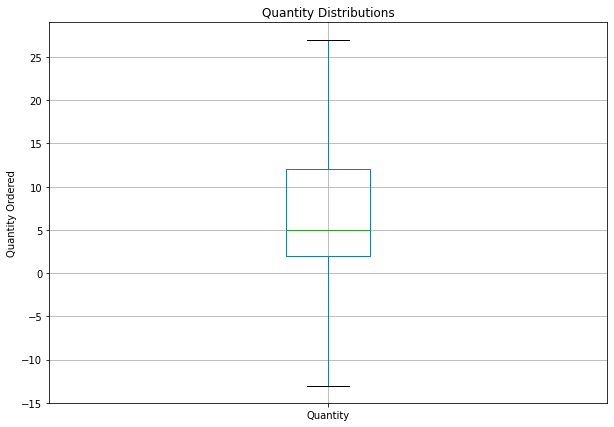

In [167]:
# checking the distributions of quantity

ax = r_df[['Quantity']].boxplot(
    showfliers = False, figsize = (10,7)
    )

ax.set_ylabel('Quantity Ordered')
ax.set_title('Quantity Distributions')

plt.show()

# explanation:
# existence of negative orders




plt.show()

(805620, 8)
(824364, 8)


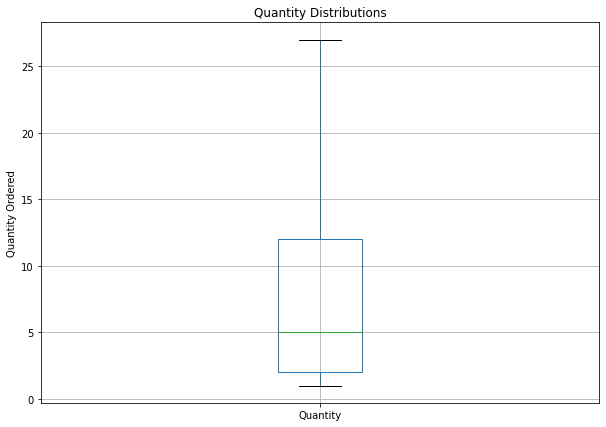

In [205]:
# filtering of negative orders

# filtering
r_df1 =r_df.loc[r_df['Quantity'] > 0]

print(r_df1.shape)   # filtered df
print(r_df.shape)    # original df

# visualisations
ax = r_df1[['Quantity']].boxplot(
    showfliers = False, figsize = (10,7)
    )

ax.set_ylabel('Quantity Ordered')
ax.set_title('Quantity Distributions')

plt.show()

# explanation:
# negative orders removed
# now the orders are now drop to 805620 request

 ## Time Series Analysis
 - understanding the trend of purchase using time series

In [254]:
# understanding the trend of purchase using time series

# convert to datetime
# date object conversions from unknown type to datetime format
r_df1.loc['InvoiceDate'] = pd.to_datetime(r_df1['InvoiceDate'])
#sales_df['CustomerCreateDate'] = pd.to_datetime(sales_df['CustomerCreateDate'])

# first convert date to month to see unique purchase 
orders_df_by_months = r_df1.set_index('InvoiceDate')['Invoice'].resample('M').nunique()
print(orders_df_by_months.head(2))


InvoiceDate
2009-12-31    1512
2010-01-31    1011
Name: Invoice, dtype: int64


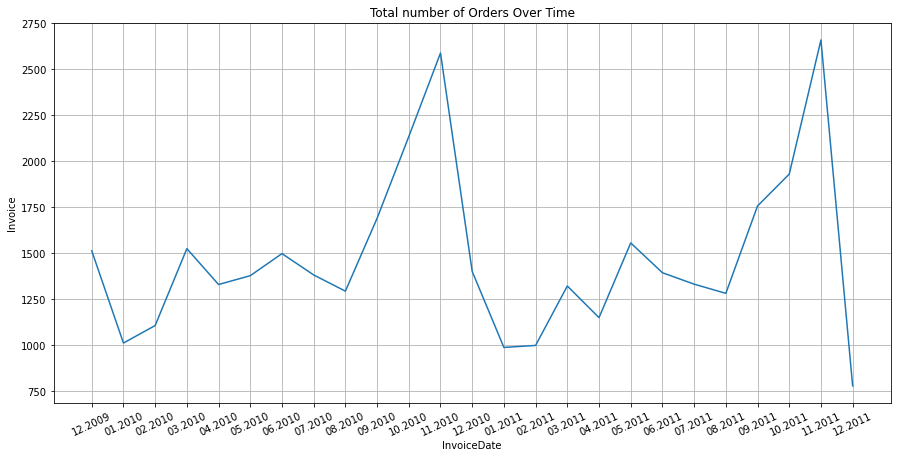

In [256]:
# visualisation
ax = pd.DataFrame(orders_df_by_months.values).plot(
    grid = True, 
    figsize = (15,7),
    legend = False
)

ax.set_xlabel('InvoiceDate')
ax.set_ylabel('Invoice')
ax.set_title('Total number of Orders Over Time')

plt.xticks(
    range(len(orders_df_by_months.index)),
    [x.strftime('%m.%Y') for x in orders_df_by_months.index],
    rotation = 25   # x labels position
)

plt.show()

In [267]:
# looking at the date with drop in quantities

inv_date = r_df1.loc[
    r_df1['InvoiceDate'] >= '2009-12-01', 'InvoiceDate'
]
print('Min date: %s\nMax date: %s' % (inv_date.min(), inv_date.max()))

Min date: 2009-12-01 07:45:00
Max date: 2011-12-09 12:50:00


In [340]:
# customers trend over time by invoice

# first aggregate by repeated invoice
customer_by_inv_df= r_df1.groupby(
    by= ['Invoice', 'InvoiceDate']
).agg(
    {'Sales': sum,
    'Customer ID': max,
    'Country':max}
).reset_index()

customer_by_inv_df.head(5)

# repeated customers by months
repeat_cust_by_months_df = customer_by_inv_df.set_index('InvoiceDate').groupby([
   pd.Grouper(freq='M'),'Customer ID']).filter(lambda x: len(x) >1).resample('M').nunique()['Customer ID']
print(repeat_cust_by_months_df.head(3))

# unique customers by months
unique_cust_by_months_df = r_df1.set_index('InvoiceDate')['Customer ID'].resample('M').nunique()
print(unique_cust_by_months_df.head(3))


InvoiceDate
2009-12-31    286
2010-01-31    148
2010-02-28    175
Freq: M, Name: Customer ID, dtype: int64
InvoiceDate
2009-12-31    955
2010-01-31    720
2010-02-28    774
Name: Customer ID, dtype: int64


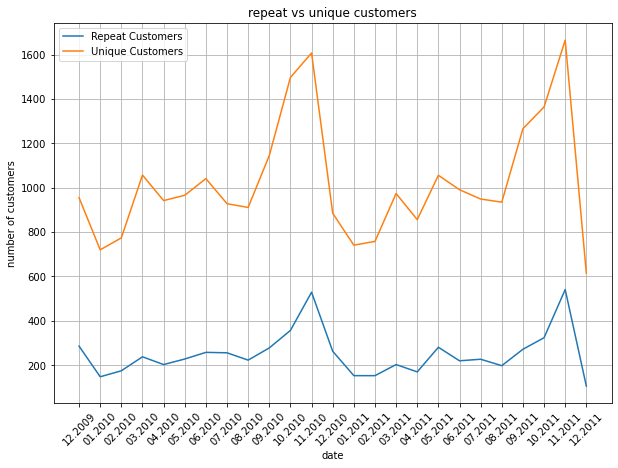

In [269]:
# visualisations of Repeat vs Unique Customers
ax = pd.DataFrame(repeat_cust_by_months_df.values).plot(
    figsize = (10,7)
)

pd.DataFrame(unique_cust_by_months_df.values).plot(
    ax = ax, grid = True
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('repeat vs unique customers')

ax.legend(['Repeat Customers', 'Unique Customers'])

plt.xticks(
    range(len(repeat_cust_by_months_df.index)),
    [x.strftime('%m.%Y') for x in repeat_cust_by_months_df.index],
    rotation = 45
)

plt.show()



## Time Series Analysis
- Analysis using unique customers for number of 

             Customer ID
InvoiceDate             
2009-12-31           286
2010-01-31           148
2010-02-28           175


(25, 1)

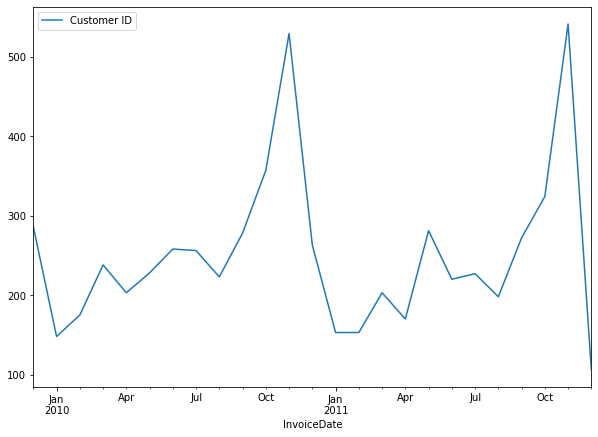

In [385]:
# unique customers by months

repeat_cust_by_months_df1 = pd.DataFrame(repeat_cust_by_months_df)
repeat_cust_by_months_ts = repeat_cust_by_months_df1.asfreq(pd.infer_freq(repeat_cust_by_months_df1.index))

print(repeat_cust_by_months_ts.head(3))

# examing the time series plot to check for stationarity, seasonlity, cyclicity
repeat_cust_by_months_ts.plot()
repeat_cust_by_months_ts.shape

In [386]:
# Further proof of stationarity at 0.05 confidence interval
# ADF is a unit root test for stationarity of a time series
# H0: there is a unit root
# H1: there is no unit root

from statsmodels.tsa.stattools import adfuller

ar_lag = adfuller(repeat_cust_by_months_ts['Customer ID'], autolag = 'BIC')
print(ar_lag)


# output explanation
# - since p-value is less than 0.05, the null hypothesis is rejected
# - similarily, the existence of strong negative values of the critical values also shows a rejected of hypothesis
# - hence, there is a stationarity with the sale's trend

(-3.82570453689756, 0.00265500550634816, 0, 24, {'1%': -3.7377092158564813, '5%': -2.9922162731481485, '10%': -2.635746736111111}, 192.30651502835025)


In [410]:
#create train and test data

#create train sets
start_date = pd.to_datetime('2009-12-01')
end_date = pd.to_datetime('2011-06-01')
train_data = repeat_cust_by_months_ts[start_date: end_date ]

# index train sets
#train_data = train_dataset.asfreq(pd.infer_freq(train_dataset.index))

#create test sets
test_start_date = len(train_data)
test_end_date = len(repeat_cust_by_months_ts) -1

test_data = repeat_cust_by_months_ts[test_start_date: ]

test_data.head()


,Customer ID
InvoiceDate,
2011-06-30,220
2011-07-31,227
2011-08-31,198
2011-09-30,272
2011-10-31,324


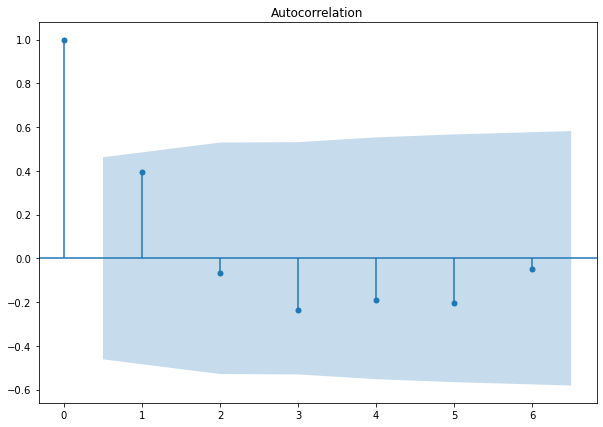

In [390]:
# model analyse autocorelation lags
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(train_data['Customer ID'], lags=6)

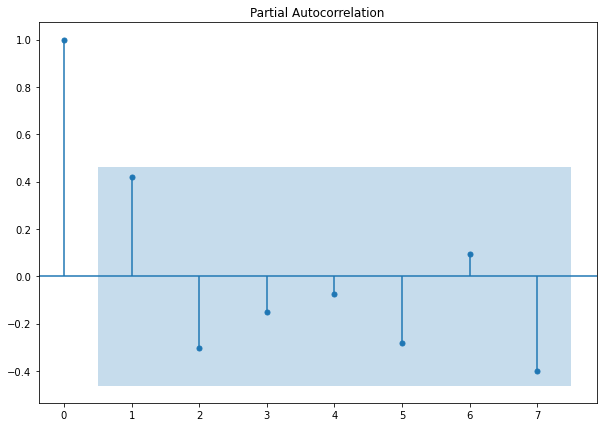

In [391]:
pacf_plt = plot_pacf(train_data['Customer ID'], lags = 7)

In [392]:
# model and extract correlation coefficients
from statsmodels.tsa.ar_model import AutoReg
from time import time

start =time()
ar_mdl = AutoReg(train_data['Customer ID'], lags =5, seasonal=False, old_names = True).fit()
end = time()
print('ar_mdl model training time:', end - start)
print(ar_mdl.summary())

# output explanations


ar_mdl model training time: 0.004999876022338867
                            AutoReg Model Results                             
Dep. Variable:            Customer ID   No. Observations:                   18
Model:                     AutoReg(5)   Log Likelihood                 -74.272
Method:               Conditional MLE   S.D. of innovations             73.283
Date:                Tue, 26 Jan 2021   AIC                              9.666
Time:                        17:13:34   BIC                              9.970
Sample:                    05-31-2010   HQIC                             9.603
                         - 05-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        365.8888    122.036      2.998      0.003     126.703     605.075
Customer ID.L1     0.4976      0.250      1.993      0.046       0.008

In [411]:
# predictions. get prediction data, and residual or error

# get prediction data
#get_start_date= test_data.index[0]('Customer ID')
#get_end_date = test_data.index[-1]

# prediction
predicted = ar_mdl.predict(start=len(train_data), end =len(repeat_cust_by_months_ts)-1, dynamic=False)
print(predicted)
print(test_data)

2011-06-30    348.618697
2011-07-31    360.360813
2011-08-31    287.553978
2011-09-30    255.746060
2011-10-31    225.158602
2011-11-30    215.516622
2011-12-31    216.026436
Freq: M, dtype: float64
             Customer ID
InvoiceDate             
2011-06-30           220
2011-07-31           227
2011-08-31           198
2011-09-30           272
2011-10-31           324
2011-11-30           541
2011-12-31           106


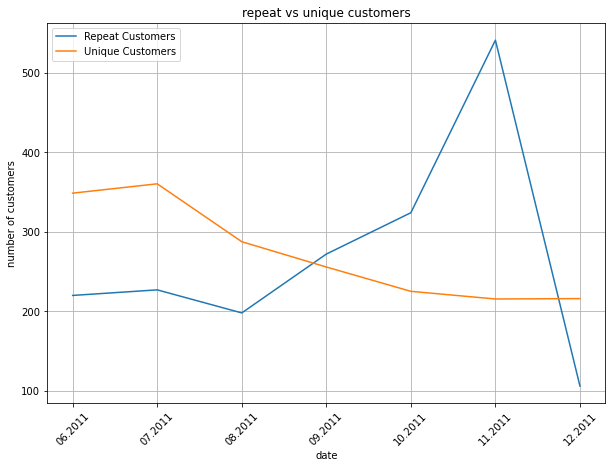

In [412]:
# visualisations of Repeat vs Unique Customers
ax = pd.DataFrame(test_data.values).plot(
    figsize = (10,7)
)

pd.DataFrame(predicted.values).plot(
    ax = ax, grid = True
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('repeat vs unique customers')

ax.legend(['Repeat Customers', 'Unique Customers'])

plt.xticks(
    range(len(predicted.index)),
    [x.strftime('%m.%Y') for x in predicted.index],
    rotation = 45
)

plt.show()


In [416]:
# error
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(test_data, predicted))
print(rmse)

156.03426789866114


In [420]:
# future forecast

forcast_by_12 = ar_mdl.predict(start=len(repeat_cust_by_months_ts) +1,
                               end =len(repeat_cust_by_months_ts)+12, dynamic=False)
print(forcast_by_12)
print(len(forcast_by_12))

2012-02-29    283.584410
2012-03-31    296.828370
2012-04-30    286.590617
2012-05-31    273.087940
2012-06-30    254.842571
2012-07-31    242.785385
2012-08-31    240.133574
2012-09-30    250.455938
2012-10-31    263.008971
2012-11-30    272.322152
2012-12-31    274.309609
2013-01-31    270.985666
Freq: M, dtype: float64
12


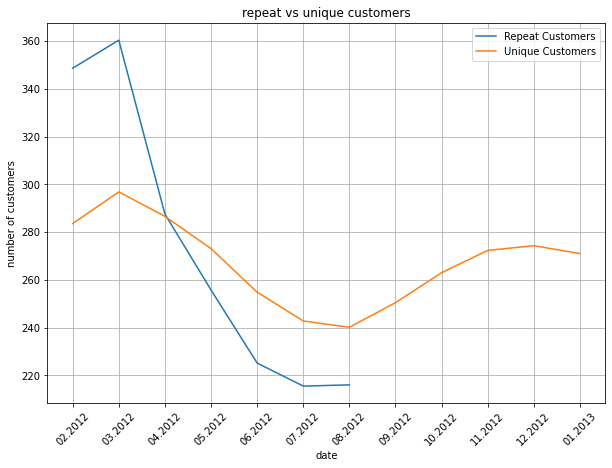

In [422]:
# visualisations of Repeat vs Unique Customers
ax = pd.DataFrame(predicted.values).plot(
    figsize = (10,7)
)

pd.DataFrame(forcast_by_12.values).plot(
    ax = ax, grid = True
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('repeat vs unique customers')

ax.legend(['Repeat Customers', 'Unique Customers'])

plt.xticks(
    range(len(forcast_by_12.index)),
    [x.strftime('%m.%Y') for x in forcast_by_12.index],
    rotation = 45
)

plt.show()
